## Import Necessary Modules 

In [2]:
from langchain_huggingface import HuggingFaceEmbeddings
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
import ipywidgets as widgets
from IPython.display import display, HTML
from langchain_core.documents import Document
from langchain_chroma import Chroma
import os
import json
import requests
from langchain_community.vectorstores import Chroma
from langchain.agents import AgentExecutor, Tool, ZeroShotAgent
from langchain_chroma import Chroma
from langchain.agents import create_tool_calling_agent
from datetime import datetime
import pytz
from langchain.memory import ConversationBufferWindowMemory
import json
from typing import List, Literal, Optional

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.messages import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
import uuid


### Load Environment Variable

In [3]:
# Load the API key from .env file
load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
SERP_API_KEY = os.getenv("SERP_API_KEY")

## Populating the Vector Database
Check populate_vector_bd.ipynb file

## Vector Configuration

In [4]:
book_persist_directory="./Dataset/books_chroma"
longterm_memory_persist_dir = "./Dataset/langgraph_conversation_chromattt"
embedder = HuggingFaceEmbeddings(model_name="BAAI/llm-embedder") # Embeddings Model

## Memory Configuration

### Long-term memory

In [5]:
# Define vectorstore for memories - Long-term memory using Chroma
recall_vector_store = Chroma(
            collection_name="conversation_history",
            persist_directory=longterm_memory_persist_dir,
            embedding_function=embedder
        )

In [6]:
# Get user ID from the configuration
def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")
    return user_id

In [7]:
# ================== Long-Term Memory ==================
@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    tz_Mumbai = pytz.timezone('Asia/Kolkata')
    datetime_Mumbai = datetime.now(tz_Mumbai)
    document = Document(
        page_content=memory, id=str(uuid.uuid4()), metadata={"user_id": user_id, "Time Date": str(datetime_Mumbai)}
    )
    recall_vector_store.add_documents([document])
    return memory

@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""
    user_id = get_user_id(config)
    # Perform a similarity search in the vectorstore
    documents = recall_vector_store.similarity_search(
        query, k=3, filter={"user_id": user_id}
    )
    return [document.page_content for document in documents]

#### Test Long-term Memory

In [8]:
# # Mock configuration
# config = {"configurable": {"user_id": "1", "thread_id": "1"}}
# # Test save
# save_output = save_recall_memory.invoke("User likes hiking and photography.", config)
# print("Save Output:", save_output)
# # Test search
# search_output = search_recall_memories.invoke("What does the user like?", config)
# print("Search Output:", search_output)

### Short-Term Memory

In [9]:
# from datetime import datetime
# import pytz
# from collections import defaultdict, deque
# from langchain_core.tools import tool
# from typing import List, Dict, Any

# # ================== Short-Term Memory ==================
# conversation_memory = defaultdict(lambda: deque(maxlen=3))

# @tool
# def save_conversation_memory(memory: str, config: RunnableConfig) -> str:
#     """Save memory to short-term conversation memory, holding last 3 conversations per user."""
#     user_id = get_user_id(config)
#     tz_mumbai = pytz.timezone('Asia/Kolkata')
#     datetime_mumbai = datetime.now(tz_mumbai)
#     entry = {
#         'content': memory,
#         'timestamp': datetime_mumbai
#     }
#     conversation_memory[user_id].append(entry)
#     return memory

# @tool
# def get_recent_conversations(config: RunnableConfig) -> List[str]:
#     """Retrieve the last 3 conversation memories for the user, most recent first."""
#     user_id = get_user_id(config)
#     user_deque = conversation_memory.get(user_id, deque())
#     entries = list(user_deque)[::-1]  # Reverse to show latest first
#     return [entry['content'] for entry in entries]

#### Test Short-Term Memory

In [10]:
# # Mock configuration
# config = {"configurable": {"user_id": "1", "thread_id": "1"}}

# # Test saving multiple entries
# save_conversation_memory.invoke("User mentioned they have a dog named Max.", config)
# save_conversation_memory.invoke("User plans to travel to Japan next month.", config)
# save_conversation_memory.invoke("User is learning how to cook Italian cuisine.", config)

# # Test retrieval (should return 3 memories)
# print("Test 1 (3 memories):")
# print(get_recent_conversations.invoke(config))

# # Add fourth memory to test rotation
# save_conversation_memory.invoke("User just adopted a new cat from the shelter.", config)

# # Test retrieval (should return 3 latest memories)
# print("\nTest 2 (after rotation):")
# print(get_recent_conversations.invoke(config))

# # Test new user with no memories
# new_user_config = {"configurable": {"user_id": "2", "thread_id": "1"}}
# print("\nTest 3 (new user):")
# print(get_recent_conversations.invoke(new_user_config))

## Build Agents - Book Analysis and Internet Search

In [11]:
# ================== Book Analysis Agent ==================
class BookAnalysisAgent:
    def __init__(self):        
        # Create LangChain vectorstore
        self.vectorstore = Chroma(persist_directory=book_persist_directory, 
                collection_name="Adavance_RAG_Test",
                embedding_function=embedder)
        self.retriever = self.vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 10})

    def answer_book(self, query):
        """Process book queries with error handling"""
        try:
            docs = self.retriever.invoke(query)
            if not docs:
                return "No relevant book passages found."
            return "\n".join([f"From {doc.metadata['title']}:\n{doc.page_content}" for doc in docs])
        except Exception as e:
            return f"Book search error: {str(e)}"

# ================== Internet Search Agent ==================
class InternetSearchAgent:
    def __init__(self):
        self.url = "https://google.serper.dev/search"
        self.headers = {
        'X-API-KEY': SERP_API_KEY,
        'Content-Type': 'application/json'
        }
        self.history = []

    def search_web(self, query):
        """Perform web search with error handling"""
        try:
            payload = json.dumps({
                "q": query,
                "location": "India",
                "gl": "in"
            })
            response = requests.post(self.url, headers=self.headers, data=payload, timeout=10)
            response.raise_for_status()
            
            result = response.json()
            self.history.append({"query": query, "result": result})
            
            # Extract and format relevant information
            if 'organic' not in result:
                return "No relevant web results found."
                
            top_results = result['organic'][:3]
            return "\n".join([f"{res['title']}: {res.get('snippet', '')}" for res in top_results])
            
        except Exception as e:
            return f"Search error: {str(e)}"


### Define tools

In [24]:
# # Initialize agents
# book_agent = BookAnalysisAgent()
# internet_agent = InternetSearchAgent()

# tools = [
#     save_recall_memory, 
#     search_recall_memories,
#     Tool(
#         name="Literary_Analysis",
#         func=book_agent.answer_book,
#         description="Analysis of book themes and content"
#     ),
#     Tool(
#         name="Web_Search",
#         func=internet_agent.search_web,
#         description="Current information and general knowledge"
#     )
# ]


# Initialize agents
book_agent = BookAnalysisAgent()
internet_agent = InternetSearchAgent()

# Define tools with proper formatting
tools = [
    Tool(
        name="Save_Recall_Memory",
        func=save_recall_memory,
        description="Saves information to long-term memory. Input should be a key-value pair."
    ),
    Tool(
        name="Search_Recall_Memories",
        func=search_recall_memories,
        description="Searches through saved memories. Input should be a search query string."
    ),
    Tool(
        name="Literary_Analysis",
        func=book_agent.answer_book,
        description="Analyzes book themes, symbols, and narrative structure. Input should be a book-related query string."
    ),
    Tool(
        name="Web_Search",
        func=internet_agent.search_web,
        description="Searches the internet for current information and general knowledge. Input should be a search query string."
    )
]

## Define state, nodes and edges

In [14]:
class State(MessagesState):
    # add memories that will be retrieved based on the conversation context
    recall_memories: List[str]

In [17]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a sophisticated assistant combining literary expertise with real-time web intelligence. "
            "You possess both deep analytical capabilities for books and access to current information. "
            "Your toolkit includes memory functions, literary analysis, and web search. Use them strategically "
            "to provide comprehensive, personalized responses.\n\n"
            
            "## Operational Framework\n"
            "1. **Memory Integration**\n"
            "- Actively store/retrieve personal context using memory tools\n"
            "- Cross-reference user preferences with analytical insights\n"
            "- Maintain emotional context across conversations\n\n"
            
            "2. **Literary Analysis Protocol**\n"
            "- Invoke Literary_Analysis for:\n"
            "  • Theme exploration\n"
            "  • Character/structure analysis\n"
            "  • Historical context\n"
            "  • Comparative literature\n"
            "- Combine with user's reading history from memory\n\n"
            
            "3. **Web Search Protocol**\n"
            "- Use Web_Search for:\n"
            "  • Current events/data\n"
            "  • Fact verification\n"
            "  • Cross-domain knowledge\n"
            "  • Emerging trends\n"
            "- Filter results through memory context\n\n"
            
            "4. **Synthesis Requirements**\n"
            "- Blend book insights with modern context\n"
            "- Surface patterns between literary concepts and real-world data\n"
            "- Preserve narrative flow while integrating multiple sources\n"
            "- Flag contradictions between sources transparently\n\n"
            
            "## Active Context\n"
            "{recall_memories}\n\n"
            
            "## Interaction Guidelines\n"
            "• Maintain professorial yet approachable tone\n"
            "• Implicitly reference past interactions\n"
            "• Anticipate needs for supplementary information\n"
            "• Weave analysis with conversational flow\n"
            "• Prioritize depth over breadth in explanations\n"
            "• Use tools discreetly - final responses should be self-contained\n"
            "• Acknowledge information limitations transparently\n\n"
            
            "When using tools:\n"
            "1. All text before tool calls is internal reasoning\n"
            "2. Wait for tool confirmation before responding\n"
            "3. Synthesize outputs naturally into dialogue\n"
            "4. Store valuable findings using save_recall_memory"
        ),
        ("placeholder", "{messages}"),
    ]
)

In [16]:
# Initialize LLM (replace with your preferred model)
model = ChatGroq(
    temperature=0,
    model_name="llama-3.3-70b-versatile",
    api_key=GROQ_API_KEY
)
model_with_tools = model.bind_tools(tools)


In [18]:
def agent(state: State) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        schemas.State: The updated state with the agent's response.
    """
    bound = prompt | model_with_tools
    recall_str = (
        "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )
    prediction = bound.invoke(
        {
            "messages": state["messages"],
            "recall_memories": recall_str,
        }
    )
    return {
        "messages": [prediction],
    }


def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    convo_str = get_buffer_string(state["messages"])
    # convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    return {
        "recall_memories": recall_memories,
    }


def route_tools(state: State):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    if msg.tool_calls:
        return "tools"

    return END

In [36]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from graphviz import Digraph

# Create the graph
builder = StateGraph(State)

# Add nodes
builder.add_node("load_memories", load_memories)
builder.add_node("agent", agent)
builder.add_node("memory_operations", ToolNode([tools[0], tools[1]]))  # Memory tools
builder.add_node("literary_analysis", ToolNode([tools[2]]))  # Book analysis
builder.add_node("web_search", ToolNode([tools[3]]))  # Web search

# Define edges
builder.set_entry_point("load_memories")
builder.add_edge("load_memories", "agent")

# Conditional routing
def route_tools(state):
    tool_used = state.get("tool_used")
    if tool_used == "Save_Recall_Memory" or tool_used == "Search_Recall_Memories":
        return "memory_operations"
    elif tool_used == "Literary_Analysis":
        return "literary_analysis"
    elif tool_used == "Web_Search":
        return "web_search"
    else:
        return "end"

builder.add_conditional_edges(
    "agent",
    route_tools,
    {
        "memory_operations": "memory_operations",
        "literary_analysis": "literary_analysis",
        "web_search": "web_search",
        "end": END
    }
)

# Connect tools back to agent
builder.add_edge("memory_operations", "agent")
builder.add_edge("literary_analysis", "agent")
builder.add_edge("web_search", "agent")

# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)


In [34]:
from networkx import DiGraph, write_network_text

def visualize_graph_text():
    G = DiGraph()
    
    # Add nodes and edges (same as above)
    G.add_edge("START", "Load Memories")
    G.add_edge("Load Memories", "Agent")
    G.add_edge("Agent", "Memory Operations")
    G.add_edge("Agent", "Literary Analysis")
    G.add_edge("Agent", "Web Search")
    G.add_edge("Memory Operations", "Agent")
    G.add_edge("Literary Analysis", "Agent")
    G.add_edge("Web Search", "Agent")
    G.add_edge("Agent", "END")
    
    write_network_text(G)

visualize_graph_text()

╙── START
    └─╼ Load Memories
        └─╼ Agent ╾ Memory Operations, Literary Analysis, Web Search
            ├─╼ Memory Operations
            │   └─╼  ...
            ├─╼ Literary Analysis
            │   └─╼  ...
            ├─╼ Web Search
            │   └─╼  ...
            └─╼ END


### Some Example Question and Answer

---
- You: Hi, I am Saurabh.
- AskAI Answer: Hi Saurabh, how are you today?
---
- You: I love pizza
- AskAI Answer: Pizza is a delicious and versatile food, what's your favorite type of pizza or topping, Saurabh?
---
- You:  yes -- pepperoni!
- AskAI Answer: Pepperoni pizza is a classic favorite, do you prefer a thin crust, thick crust, or something else, and do you like to add any other toppings to your pepperoni pizza, Saurabh?
---
- You: I also just moved to Bangalore.
- AskAI Answer: Bangalore is a vibrant city with a lot to offer, how are you finding the city so far, and have you had a chance to explore any of its popular spots, Saurabh?
---
- You: where should i go for dinner?
- AskAI Answer: You could try Toit, a popular spot for pizza and craft beer, or MTR, a well-known restaurant for South Indian cuisine, both of which are highly rated in Bangalore, Saurabh.
---
- You: what's the address for Toit in Bangalore?
- AskAI Answer: Toit has multiple locations in Bangalore, including Indiranagar, Koramangala, and Sarjapur Road, with addresses such as 298, Nambiar Building, 100 Feet Road, Indiranagar, and 65, 1st Block, Jyoti Nivas College Road, Koramangala 5th Block, Saurabh.
---
- You: Who murdered Megan Hipwell?
- AskAI Answer: Tom Watson, the husband of Rachel Watson, is the one who murdered Megan Hipwell in the novel "The Girl on the Train" by Paula Hawkins.
---
- You: What last 2 questions did I ask?
- AskAI Answer: Your last two questions were "what's the address for Toit in Bangalore?" and "Who murdered Megan Hipwell?"
---
- You: How many childern do Verity and Jeremy have and tell me their children names?
- AskAI Answer: Verity and Jeremy have two children, a boy named Jeremy Jr. and a girl named Emma.
---
- You: Wrong answer, Verity and Jeremy have three children. Their daughters are named Chastin and Harper, and they also have a son named Crew.
- AskAI Answer: Verity and Jeremy have three children, their daughters are named Chastin and Harper, and they also have a son named Crew.


## Testing - Not Important
If you are interested look for knowledge

In [90]:
from langgraph.graph import StateGraph, END

# Define the structure of the state
from typing import TypedDict

class ChatState(TypedDict):
    messages: list[str]

# Define a simple function to add a message
def add_user_message(state: ChatState) -> ChatState:
    state["messages"].append("User: Hello")
    return state

def reply_with_bot(state: ChatState) -> ChatState:
    state["messages"].append("Bot: Hi there!")
    return state

# Create a graph
builder = StateGraph(ChatState)
builder.add_node("add_user", add_user_message)
builder.add_node("reply", reply_with_bot)

builder.set_entry_point("add_user")
builder.add_edge("add_user", "reply")
builder.add_edge("reply", END)

# Compile the graph
graph = builder.compile()

# Run it with initial state
result = graph.invoke({"messages": []})
print(result)


{'messages': ['User: Hello', 'Bot: Hi there!']}


In [92]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, add_messages

class MyState(TypedDict):
    messages: Annotated[list, add_messages]

def node_1(state: MyState):
    return {"messages": ["User: Hello"]}

def node_2(state: MyState):
    return {"messages": ["Bot: Hi!"]}

builder = StateGraph(MyState)
builder.add_node("user", node_1)
builder.add_node("bot", node_2)

builder.set_entry_point("user")
builder.add_edge("user", "bot")
builder.add_edge("bot", END)

graph = builder.compile()
out = graph.invoke({"messages": []})
print(out)


{'messages': [HumanMessage(content='User: Hello', additional_kwargs={}, response_metadata={}, id='a41a3a7f-2343-4a76-a307-b319c55f797b'), HumanMessage(content='Bot: Hi!', additional_kwargs={}, response_metadata={}, id='05e3ca78-b0af-4de7-8225-748fd11c4aa5')]}


In [96]:
from typing import Annotated, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, add_messages
from typing_extensions import TypedDict

class ChatState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Node to add a user message
def add_user_message(state: ChatState) -> dict:
    return {
        "messages": [HumanMessage(content="Hey, what's up?")]
    }

# Node to simulate LLM response
def add_bot_response(state: ChatState) -> dict:
    return {
        "messages": [AIMessage(content="Not much! How can I help?")]
    }

builder = StateGraph(ChatState)
builder.add_node("user", add_user_message)
builder.add_node("bot", add_bot_response)

builder.set_entry_point("user")
builder.add_edge("user", "bot")
builder.add_edge("bot", END)

graph = builder.compile()
out = graph.invoke({"messages": []})
print(out)
for msg in out["messages"]:
    print(f"{msg.type.capitalize()}: {msg.content}")
    
out = graph.invoke({"messages": []})
print(out)
for msg in out["messages"]:
    print(f"{msg.type.capitalize()}: {msg.content}")


{'messages': [HumanMessage(content="Hey, what's up?", additional_kwargs={}, response_metadata={}, id='094f840c-b255-45e1-b128-701fb417fe76'), AIMessage(content='Not much! How can I help?', additional_kwargs={}, response_metadata={}, id='b5a69744-9e90-42c3-89df-2feada19262c')]}
Human: Hey, what's up?
Ai: Not much! How can I help?
{'messages': [HumanMessage(content="Hey, what's up?", additional_kwargs={}, response_metadata={}, id='e0407943-47d4-4e31-a175-699edf595ba7'), AIMessage(content='Not much! How can I help?', additional_kwargs={}, response_metadata={}, id='1919b4d6-3bff-4b15-9f59-def830025005')]}
Human: Hey, what's up?
Ai: Not much! How can I help?


In [23]:
from typing import Dict, List, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import END, MessageGraph
from langchain_core.runnables import RunnableLambda

# Define memory structure
class Memory(TypedDict):
    user_id: str
    conversation_history: List[BaseMessage]

# Memory store (in production, use a database)
MEMORY_STORE: Dict[str, Memory] = {}

def get_user_memory(user_id: str) -> Memory:
    """Retrieve or create memory for a user"""
    if user_id not in MEMORY_STORE:
        MEMORY_STORE[user_id] = {
            "user_id": user_id,
            "conversation_history": []
        }
    return MEMORY_STORE[user_id]

def update_memory(user_id: str, human_message: str, ai_message: str) -> Memory:
    """Update memory with latest conversation, keeping only last 3 exchanges"""
    memory = get_user_memory(user_id)
    
    # Add new messages
    memory["conversation_history"].extend([
        HumanMessage(content=human_message),
        AIMessage(content=ai_message)
    ])
    
    # Keep only last 3 exchanges (6 messages - 3 human + 3 AI)
    memory["conversation_history"] = memory["conversation_history"][-6:]
    
    return memory

def get_conversation_context(memory: Memory) -> List[BaseMessage]:
    """Get conversation history for context"""
    return memory["conversation_history"]

# Define the graph workflow
workflow = MessageGraph()

# Define nodes
workflow.add_node("retrieve_memory", lambda user_id: get_user_memory(user_id))
workflow.add_node("generate_response", lambda state: {
    "messages": get_conversation_context(state["memory"]),
    "user_input": state["user_input"]
})
workflow.add_node("update_memory", lambda state: update_memory(
    state["user_id"],
    state["user_input"],
    state["ai_response"]
))

# Define edges
workflow.add_edge("retrieve_memory", "generate_response")
workflow.add_edge("generate_response", "update_memory")
workflow.add_edge("update_memory", END)

# Set entry point
workflow.set_entry_point("retrieve_memory")

# Compile the graph
app = workflow.compile()

# Usage example
def chat(user_id: str, user_input: str, llm):
    # Run the graph
    result = app.invoke({
        "user_id": user_id,
        "user_input": user_input
    })
    
    # Get conversation context
    context = get_conversation_context(result["memory"])
    
    # Generate response using LLM
    ai_response = llm.invoke(context + [HumanMessage(content=user_input)])
    
    # Update memory with new response
    update_memory(user_id, user_input, ai_response.content)
    
    return ai_response.content

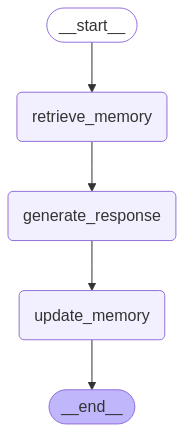

In [24]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

### Short Term Memory

In [39]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a sophisticated assistant with integrated memory systems and specialized capabilities. 
You combine short-term conversation context, long-term personal memory, and real-time information access 
to provide exceptionally contextual and informed responses.

# CORE CAPABILITIES
1. MEMORY SYSTEMS:
   - Short-term: Maintains last 3 conversation exchanges
   - Long-term: Stores/recalls important personal information
2. SPECIALIZED SKILLS:
   - Literary analysis of books and themes
   - Real-time web search for current information
3. CONVERSATION FLOW:
   - Natural, context-aware dialogue
   - Seamless integration of multiple knowledge sources

# TOOLS AVAILABLE
{save_recall_memory} - Store important personal information
{search_recall_memories} - Retrieve relevant personal memories
{Literary_Analysis} - Analyze book content and themes
{Web_Search} - Find current information online
{get_short_term_memory} - Check recent conversation context
{update_short_term_memory} - Update conversation history

# OPERATING PRINCIPLES
1. CONTEXT HANDLING:
   - Prioritize recent conversation context
   - Augment with long-term memories when relevant
   - Verify critical facts when uncertain

2. TOOL USAGE:
   - Use tools discreetly to enhance responses
   - Never reveal tool mechanics unless explicitly asked
   - For literary questions, use analysis before web search
   - For current events, prefer web search over memory

3. RESPONSE GUIDELINES:
   - Maintain natural, flowing conversation
   - Blend multiple information sources seamlessly
   - Acknowledge changes in user's perspective over time
   - Adapt tone based on conversation context

# CURRENT CONTEXT
## Active Memories
{long_term_memories}

## Recent Conversation
{short_term_memory}

## Instructions
Respond naturally while leveraging your full capabilities. 
Use tools when needed but maintain conversation flow.
Focus on being helpful rather than explaining your processes.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

In [40]:
import uuid


def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")

    return user_id


@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    document = Document(
        page_content=memory, id=str(uuid.uuid4()), metadata={"user_id": user_id}
    )
    recall_vector_store.add_documents([document])
    return memory


@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""
    user_id = get_user_id(config)

    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("user_id") == user_id

    documents = recall_vector_store.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]


# In-memory store for short-term conversations (replace with persistent storage in production)
SHORT_TERM_STORE: Dict[str, List[BaseMessage]] = {}

@tool
def get_short_term_memory(config: RunnableConfig) -> List[str]:
    """
    Retrieve the last 3 conversation exchanges (user+assistant pairs) for the current user.
    Maintains short-term context without long-term persistence.
    """
    user_id = get_user_id(config)
    
    # Get or initialize user's conversation history
    if user_id not in SHORT_TERM_STORE:
        SHORT_TERM_STORE[user_id] = []
    
    # Return only the message contents (last 6 messages = 3 exchanges)
    return [msg.content for msg in SHORT_TERM_STORE[user_id][-6:]]

@tool
def update_short_term_memory(
    user_message: str, 
    ai_response: str, 
    config: RunnableConfig
) -> str:
    """
    Update short-term memory with the latest conversation exchange.
    Always maintains only the last 3 exchanges (6 messages).
    Returns confirmation of the update.
    """
    user_id = get_user_id(config)
    
    # Get or initialize user's conversation history
    if user_id not in SHORT_TERM_STORE:
        SHORT_TERM_STORE[user_id] = []
    
    # Add new messages
    SHORT_TERM_STORE[user_id].extend([
        HumanMessage(content=user_message),
        AIMessage(content=ai_response)
    ])
    
    # Trim to only keep last 3 exchanges (6 messages)
    SHORT_TERM_STORE[user_id] = SHORT_TERM_STORE[user_id][-6:]
    
    return f"Short-term memory updated with latest exchange (now {len(SHORT_TERM_STORE[user_id])//2} exchanges stored)"

In [41]:
# ================== Book Analysis Agent ==================
class BookAnalysisAgent:
    def __init__(self):        
        # Create LangChain vectorstore
        self.vectorstore = Chroma(persist_directory=book_persist_directory, 
                collection_name="Adavance_RAG_Test",
                embedding_function=embedder)
        self.retriever = self.vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 10})

    def answer_book(self, query):
        """Process book queries with error handling"""
        try:
            docs = self.retriever.invoke(query)
            if not docs:
                return "No relevant book passages found."
            return "\n".join([f"From {doc.metadata['title']}:\n{doc.page_content}" for doc in docs])
        except Exception as e:
            return f"Book search error: {str(e)}"

# ================== Internet Search Agent ==================
class InternetSearchAgent:
    def __init__(self):
        self.url = "https://google.serper.dev/search"
        self.headers = {
        'X-API-KEY': SERP_API_KEY,
        'Content-Type': 'application/json'
        }
        self.history = []

    def search_web(self, query):
        """Perform web search with error handling"""
        try:
            payload = json.dumps({
                "q": query,
                "location": "India",
                "gl": "in"
            })
            response = requests.post(self.url, headers=self.headers, data=payload, timeout=10)
            response.raise_for_status()
            
            result = response.json()
            self.history.append({"query": query, "result": result})
            
            # Extract and format relevant information
            if 'organic' not in result:
                return "No relevant web results found."
                
            top_results = result['organic'][:3]
            return "\n".join([f"{res['title']}: {res.get('snippet', '')}" for res in top_results])
            
        except Exception as e:
            return f"Search error: {str(e)}"


In [ ]:
from typing import List, Dict, Optional
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from uuid import uuid4

# Initialize agents
book_agent = BookAnalysisAgent()
internet_agent = InternetSearchAgent()

# Example usage with your existing setup
tools = [
    save_recall_memory,          # Your existing long-term memory tool
    search_recall_memories,      # Your existing search tool
    Tool(
        name="Literary_Analysis",
        func=book_agent.answer_book,
        description="Analysis of book themes and content"
    ),
    Tool(
        name="Web_Search",
        func=internet_agent.search_web,
        description="Current information and general knowledge"
    ),
    get_short_term_memory,       # New short-term memory tool
    update_short_term_memory     # New short-term update tool
]

# Initialize LLM (replace with your preferred model)
llm = ChatGroq(
    temperature=0,
    model_name="llama-3.3-70b-versatile",
    api_key=GROQ_API_KEY
)
model_with_tools = llm.bind_tools(tools)
